In [1]:
# Install necessary packages
!pip install rdkit-pypi numpy pandas matplotlib scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 17.5 MB/s eta 0:00:00


In [2]:
# Fix NumPy compatibility issue
!pip install "numpy<2.0.0"
!pip install --upgrade rdkit-pypi  # Reinstall rdkit to ensure compatibility

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [7]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# RDKit imports
from rdkit import Chem
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True  # For better molecule rendering

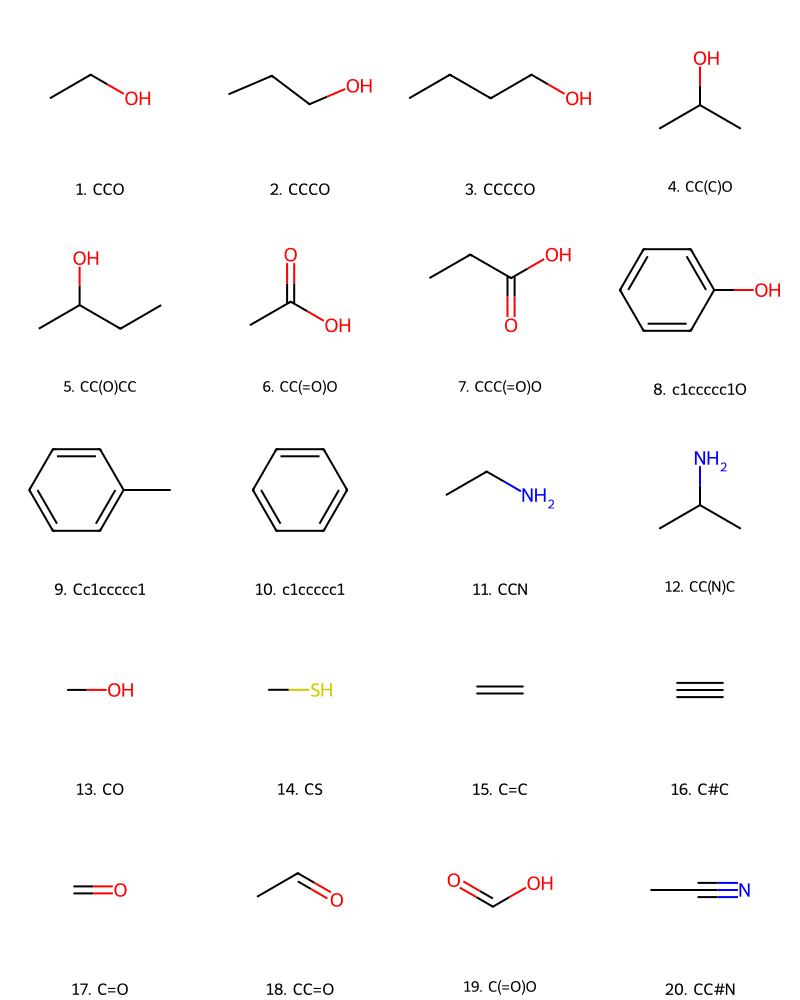

In [8]:
# Define molecules for training
smiles_list = [
    'CCO',         # Ethanol
    'CCCO',        # 1-Propanol
    'CCCCO',       # 1-Butanol
    'CC(C)O',      # 2-Propanol
    'CC(O)CC',     # 2-Butanol
    'CC(=O)O',     # Acetic acid
    'CCC(=O)O',    # Propionic acid
    'c1ccccc1O',   # Phenol
    'Cc1ccccc1',   # Toluene
    'c1ccccc1',    # Benzene
    'CCN',         # Ethylamine
    'CC(N)C',      # Isopropylamine
    'CO',          # Methanol
    'CS',          # Methanethiol
    'C=C',         # Ethylene
    'C#C',         # Acetylene
    'C=O',         # Formaldehyde
    'CC=O',        # Acetaldehyde
    'C(=O)O',      # Formic acid
    'CC#N'         # Acetonitrile
]

# Convert SMILES to RDKit molecules
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

# Add hydrogen atoms (essential for force field work)
mols_with_h = [Chem.AddHs(mol) for mol in mols]

# Display the molecules to verify
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200),
                         legends=[f"{i+1}. {smi}" for i, smi in enumerate(smiles_list)])
display(img)

In [9]:
# Generate 3D coordinates for all molecules
mols_3d = []
successful_indices = []  # Keep track of which molecules were successfully processed

for i, mol in enumerate(mols_with_h):
    try:
        # Generate 3D coordinates
        status = AllChem.EmbedMolecule(mol, randomSeed=42)

        if status == 0:  # Success
            # Optimize the geometry using MMFF
            AllChem.MMFFOptimizeMolecule(mol)
            mols_3d.append(mol)
            successful_indices.append(i)
        else:
            print(f"Failed to generate 3D coordinates for molecule {i+1}: {smiles_list[i]}")
    except Exception as e:
        print(f"Error processing molecule {i+1}: {smiles_list[i]}")
        print(f"Error message: {str(e)}")

print(f"Successfully generated 3D structures for {len(mols_3d)} out of {len(mols_with_h)} molecules")

Successfully generated 3D structures for 20 out of 20 molecules


In [12]:
def extract_bond_features(mol, mol_idx):
    """Extract features for all bonds in a molecule"""
    features = []

    # Get MMFF94 properties for reference (our "quantum data" substitute)
    mmff_props = AllChem.MMFFGetMoleculeProperties(mol)

    if mmff_props is None:
        return pd.DataFrame()  # Return empty dataframe if MMFF fails

    # Get bond features
    for bond in mol.GetBonds():
        atom1_idx = bond.GetBeginAtomIdx()
        atom2_idx = bond.GetEndAtomIdx()
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()

        # Skip if either atom is hydrogen (for simplicity)
        # Uncomment if you want to include hydrogen bonds
        # if atom1.GetSymbol() == 'H' or atom2.GetSymbol() == 'H':
        #     continue

        # Basic features
        feature_dict = {
            'molecule_idx': mol_idx,
            'atom1_idx': atom1_idx,
            'atom2_idx': atom2_idx,
            'bond_type': float(bond.GetBondTypeAsDouble()),
            'is_conjugated': int(bond.GetIsConjugated()),
            'is_in_ring': int(bond.IsInRing()),
            'atom1_element': atom1.GetSymbol(),
            'atom2_element': atom2.GetSymbol(),
            'atom1_atomic_num': atom1.GetAtomicNum(),
            'atom2_atomic_num': atom2.GetAtomicNum(),
            'atom1_degree': atom1.GetDegree(),
            'atom2_degree': atom2.GetDegree(),
            'atom1_implicit_valence': atom1.GetImplicitValence(),
            'atom2_implicit_valence': atom2.GetImplicitValence(),
            'atom1_formal_charge': atom1.GetFormalCharge(),
            'atom2_formal_charge': atom2.GetFormalCharge(),
            'atom1_num_radical_electrons': atom1.GetNumRadicalElectrons(),
            'atom2_num_radical_electrons': atom2.GetNumRadicalElectrons(),
            'atom1_hybridization': int(atom1.GetHybridization()),
            'atom2_hybridization': int(atom2.GetHybridization()),
            'atom1_is_aromatic': int(atom1.GetIsAromatic()),
            'atom2_is_aromatic': int(atom2.GetIsAromatic()),
            'atom1_is_in_ring': int(atom1.IsInRing()),
            'atom2_is_in_ring': int(atom2.IsInRing())
        }

        # Extract MMFF parameters (our "target values" - simulating QM data)
        try:
            mmff_bond = mmff_props.GetMMFFBondStretchParams(mol, atom1_idx, atom2_idx)
            if mmff_bond:
                feature_dict['mmff_kb'] = mmff_bond[0]  # Force constant
                feature_dict['mmff_r0'] = mmff_bond[1]  # Equilibrium bond length
            else:
                continue  # Skip bonds without MMFF parameters
        except:
            continue  # Skip if MMFF parameters can't be calculated

        # Get actual bond length from the 3D conformer
        conf = mol.GetConformer()
        bond_length = rdMolTransforms.GetBondLength(conf, atom1_idx, atom2_idx)
        feature_dict['bond_length'] = bond_length

        features.append(feature_dict)

    return pd.DataFrame(features)

# Collect features from all molecules with 3D structures
all_bond_features = []

for i, (mol, orig_idx) in enumerate(zip(mols_3d, successful_indices)):
    bond_features = extract_bond_features(mol, orig_idx)
    if not bond_features.empty:
        all_bond_features.append(bond_features)

# Combine all features into one DataFrame
bond_data = pd.concat(all_bond_features, ignore_index=True)

# Display the first few rows
print(f"Collected {len(bond_data)} bond features")
bond_data.head()

Collected 172 bond features


,molecule_idx,atom1_idx,atom2_idx,bond_type,is_conjugated,is_in_ring,atom1_element,atom2_element,atom1_atomic_num,atom2_atomic_num,...,atom2_num_radical_electrons,atom1_hybridization,atom2_hybridization,atom1_is_aromatic,atom2_is_aromatic,atom1_is_in_ring,atom2_is_in_ring,mmff_kb,mmff_r0,bond_length
0,0,0,1,1.0,0,0,C,C,6,6,...,0,4,4,0,0,0,0,0,4.258,1.514604
1,0,1,2,1.0,0,0,C,O,6,8,...,0,4,4,0,0,0,0,0,5.047,1.420178
2,0,0,3,1.0,0,0,C,H,6,1,...,0,4,0,0,0,0,0,0,4.766,1.094971
3,0,0,4,1.0,0,0,C,H,6,1,...,0,4,0,0,0,0,0,0,4.766,1.093559
4,0,0,5,1.0,0,0,C,H,6,1,...,0,4,0,0,0,0,0,0,4.766,1.094948


In [13]:
# Prepare features for machine learning
def prepare_ml_features(bond_data):
    """Prepare bond data for machine learning"""
    # Make a copy to avoid modifying the original
    df = bond_data.copy()

    # Drop rows with missing target values
    df = df.dropna(subset=['mmff_kb', 'mmff_r0'])

    # Select features for the model
    feature_cols = [
        'bond_type', 'is_conjugated', 'is_in_ring',
        'atom1_atomic_num', 'atom2_atomic_num',
        'atom1_degree', 'atom2_degree',
        'atom1_hybridization', 'atom2_hybridization',
        'atom1_is_aromatic', 'atom2_is_aromatic',
        'atom1_is_in_ring', 'atom2_is_in_ring'
    ]

    # Handle categorical features with one-hot encoding
    categorical_features = ['atom1_element', 'atom2_element']

    # Create feature matrix with one-hot encoding for categorical features
    X = pd.get_dummies(df[feature_cols + categorical_features],
                      columns=categorical_features,
                      drop_first=False)

    # Target variables
    y_kb = df['mmff_kb']  # Force constant
    y_r0 = df['mmff_r0']  # Equilibrium bond length

    return X, y_kb, y_r0, df

# Prepare data
X, y_kb, y_r0, clean_bond_data = prepare_ml_features(bond_data)

print(f"Feature matrix shape: {X.shape}")
print(f"Number of samples: {len(y_kb)}")

Feature matrix shape: (172, 22)
Number of samples: 172


In [14]:
# Split data into training and test sets
X_train, X_test, y_kb_train, y_kb_test, y_r0_train, y_r0_test = train_test_split(
    X, y_kb, y_r0, test_size=0.2, random_state=42)

# Train Random Forest model for force constants (kb)
model_kb = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_kb.fit(X_train, y_kb_train)

# Train Random Forest model for equilibrium bond lengths (r0)
model_r0 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_r0.fit(X_train, y_r0_train)

# Make predictions on test set
y_kb_pred = model_kb.predict(X_test)
y_r0_pred = model_r0.predict(X_test)

# Evaluate models
kb_mse = mean_squared_error(y_kb_test, y_kb_pred)
kb_r2 = r2_score(y_kb_test, y_kb_pred)
r0_mse = mean_squared_error(y_r0_test, y_r0_pred)
r0_r2 = r2_score(y_r0_test, y_r0_pred)

print("Force Constant (kb) Model Performance:")
print(f"Mean Squared Error: {kb_mse:.4f}")
print(f"R² Score: {kb_r2:.4f}")
print("\nEquilibrium Bond Length (r0) Model Performance:")
print(f"Mean Squared Error: {r0_mse:.6f}")
print(f"R² Score: {r0_r2:.4f}")

Force Constant (kb) Model Performance:
Mean Squared Error: 0.0000
R² Score: 1.0000

Equilibrium Bond Length (r0) Model Performance:
Mean Squared Error: 1.104912
R² Score: 0.7657


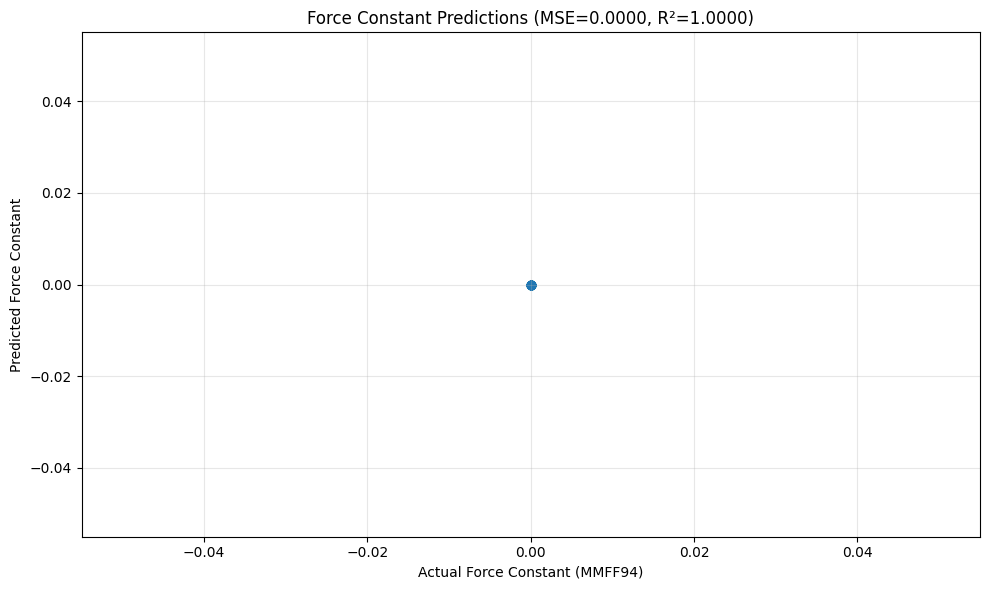

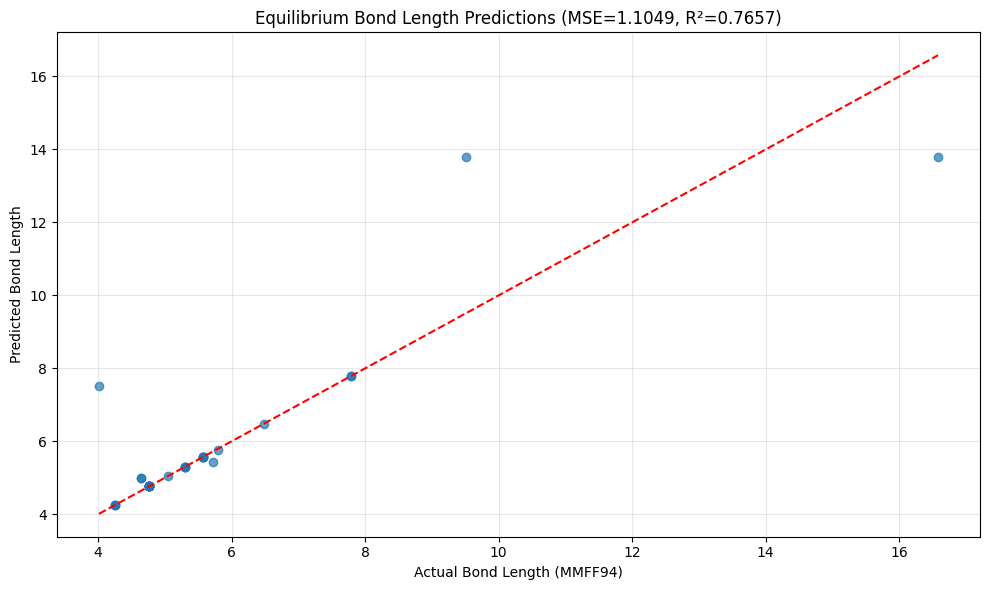

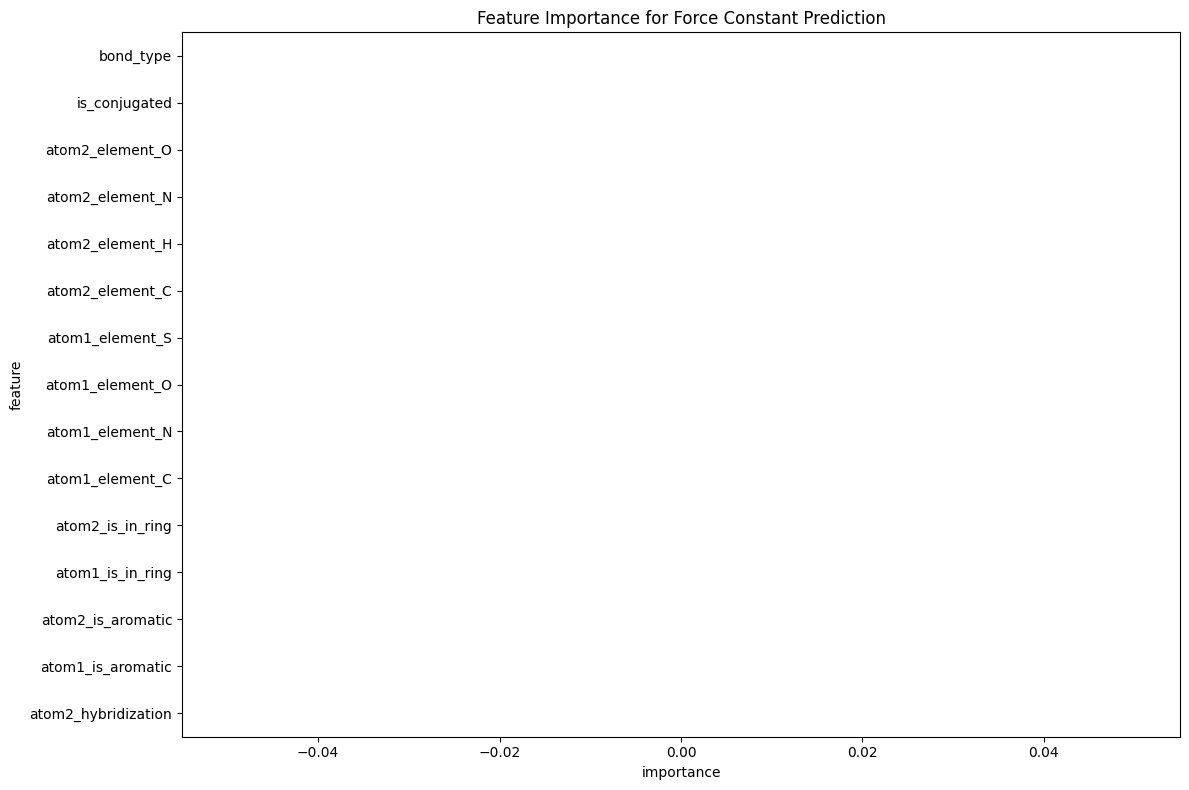

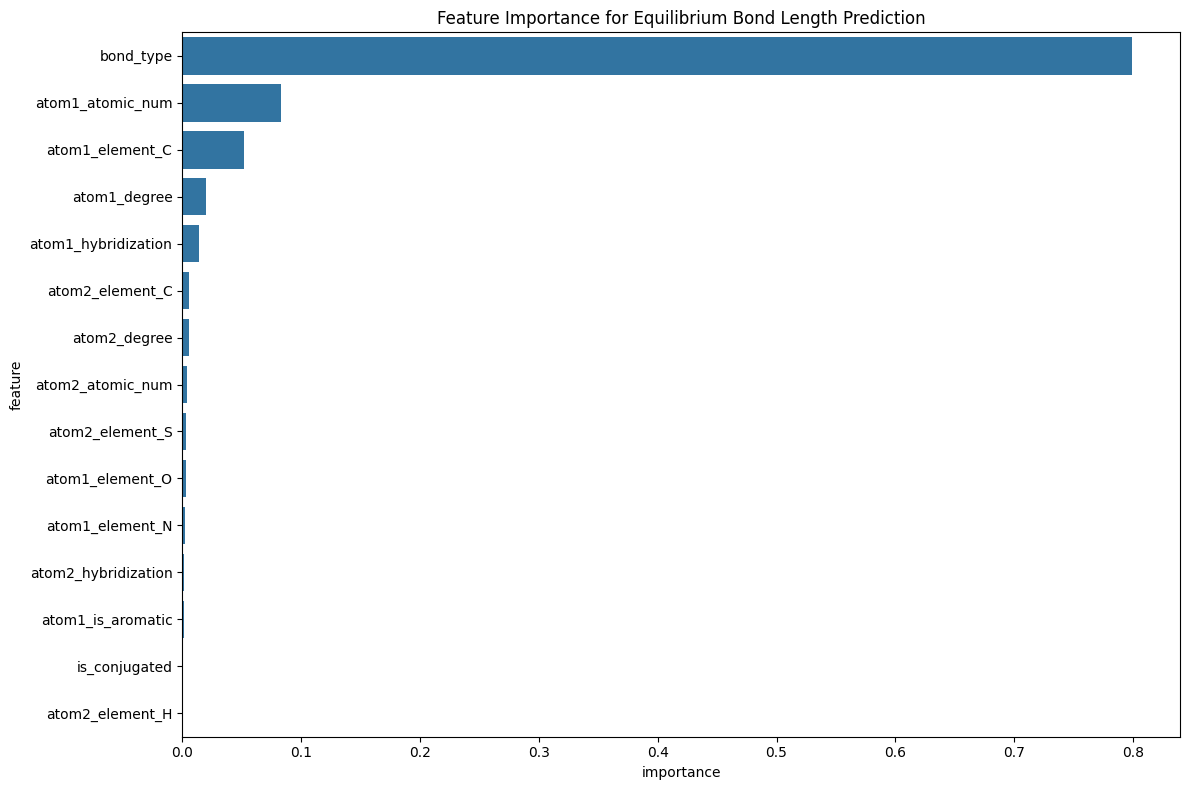

In [15]:
# Function to plot prediction results
def plot_predictions(y_true, y_pred, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.7)

    # Plot the identity line (y=x)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    plt.title(f"{title} (MSE={mse:.4f}, R²={r2:.4f})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot force constant predictions
plot_predictions(
    y_kb_test, y_kb_pred,
    "Force Constant Predictions",
    "Actual Force Constant (MMFF94)",
    "Predicted Force Constant"
)

# Plot equilibrium bond length predictions
plot_predictions(
    y_r0_test, y_r0_pred,
    "Equilibrium Bond Length Predictions",
    "Actual Bond Length (MMFF94)",
    "Predicted Bond Length"
)

# Feature importance analysis
def plot_feature_importance(model, feature_names, title, top_n=15):
    # Get feature importances
    importances = model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Plot top N features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return feature_importance

# Plot feature importance for force constant model
kb_feature_importance = plot_feature_importance(
    model_kb, X.columns,
    "Feature Importance for Force Constant Prediction"
)

# Plot feature importance for equilibrium bond length model
r0_feature_importance = plot_feature_importance(
    model_r0, X.columns,
    "Feature Importance for Equilibrium Bond Length Prediction"
)

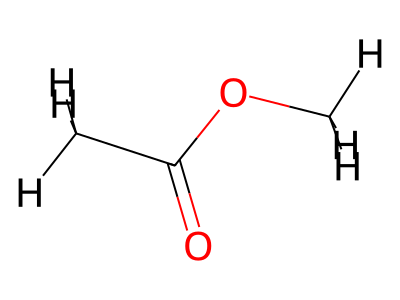

Force Constant MSE: 0.0000
Equilibrium Bond Length MSE: 0.619918


,atom1_element,atom2_element,bond_type,actual_kb,predicted_kb,actual_r0,predicted_r0,kb_error_pct,r0_error_pct
0,C,C,1.0,0,0.0,4.190,4.222630,NaN,7.787589e-01
1,C,O,2.0,0,0.0,12.950,12.950000,NaN,1.783215e-13
2,C,O,1.0,0,0.0,5.801,5.765751,NaN,-6.076292e-01
3,O,C,1.0,0,0.0,5.047,7.536352,NaN,4.932340e+01
4,C,H,1.0,0,0.0,4.766,4.766000,NaN,1.490858e-13
5,C,H,1.0,0,0.0,4.766,4.766000,NaN,1.490858e-13
6,C,H,1.0,0,0.0,4.766,4.766000,NaN,1.490858e-13
7,C,H,1.0,0,0.0,4.766,4.766000,NaN,1.490858e-13
8,C,H,1.0,0,0.0,4.766,4.766000,NaN,1.490858e-13
9,C,H,1.0,0,0.0,4.766,4.766000,NaN,1.490858e-13


In [16]:
# Function to predict parameters for a new molecule
def predict_parameters_for_new_molecule(smiles, kb_model, r0_model, feature_columns):
    """Predict force field parameters for a new molecule"""
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)

    # Extract features
    features = extract_bond_features(mol, -1)  # -1 as molecule index (doesn't matter)

    # Display the molecule
    display(Draw.MolToImage(mol, size=(400, 300)))

    if features.empty:
        print("Could not extract features for this molecule")
        return None

    # Prepare features for prediction (match training features)
    X_new = pd.get_dummies(features[['bond_type', 'is_conjugated', 'is_in_ring',
                                   'atom1_atomic_num', 'atom2_atomic_num',
                                   'atom1_degree', 'atom2_degree',
                                   'atom1_hybridization', 'atom2_hybridization',
                                   'atom1_is_aromatic', 'atom2_is_aromatic',
                                   'atom1_is_in_ring', 'atom2_is_in_ring',
                                   'atom1_element', 'atom2_element']],
                           columns=['atom1_element', 'atom2_element'])

    # Handle missing columns that were in the training data
    for col in feature_columns:
        if col not in X_new.columns:
            X_new[col] = 0

    # Only use columns that were in the training data
    X_new = X_new[feature_columns]

    # Predict parameters
    kb_pred = kb_model.predict(X_new)
    r0_pred = r0_model.predict(X_new)

    # Add predictions to the features DataFrame
    features['predicted_kb'] = kb_pred
    features['predicted_r0'] = r0_pred

    # Calculate actual MMFF parameters for comparison
    mmff_props = AllChem.MMFFGetMoleculeProperties(mol)
    actual_params = []

    for i, row in features.iterrows():
        atom1_idx = int(row['atom1_idx'])
        atom2_idx = int(row['atom2_idx'])
        try:
            mmff_bond = mmff_props.GetMMFFBondStretchParams(mol, atom1_idx, atom2_idx)
            if mmff_bond:
                actual_params.append({
                    'actual_kb': mmff_bond[0],
                    'actual_r0': mmff_bond[1]
                })
            else:
                actual_params.append({
                    'actual_kb': None,
                    'actual_r0': None
                })
        except:
            actual_params.append({
                'actual_kb': None,
                'actual_r0': None
            })

    # Add actual parameters to results
    actual_df = pd.DataFrame(actual_params)
    results = pd.concat([features, actual_df], axis=1)

    # Calculate error metrics
    mask = ~results['actual_kb'].isna()
    if mask.any():
        kb_mse = mean_squared_error(results.loc[mask, 'actual_kb'], results.loc[mask, 'predicted_kb'])
        r0_mse = mean_squared_error(results.loc[mask, 'actual_r0'], results.loc[mask, 'predicted_r0'])
        print(f"Force Constant MSE: {kb_mse:.4f}")
        print(f"Equilibrium Bond Length MSE: {r0_mse:.6f}")

    # Create result summary
    results_display = results[[
        'atom1_element', 'atom2_element', 'bond_type',
        'actual_kb', 'predicted_kb',
        'actual_r0', 'predicted_r0'
    ]].copy()

    # Calculate percentage errors
    results_display['kb_error_pct'] = 100 * (results_display['predicted_kb'] - results_display['actual_kb']) / results_display['actual_kb']
    results_display['r0_error_pct'] = 100 * (results_display['predicted_r0'] - results_display['actual_r0']) / results_display['actual_r0']

    return results_display

# Test the model on a new molecule
test_smiles = 'CC(=O)OC'  # Methyl acetate
new_mol_results = predict_parameters_for_new_molecule(test_smiles, model_kb, model_r0, X.columns)
display(new_mol_results)

In [17]:
def generate_force_field_file(molecule_smiles, kb_model, r0_model, feature_columns, output_file="force_field.txt"):
    """Generate a simple force field file from ML predictions"""
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(molecule_smiles)
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)

    # Extract features
    features = extract_bond_features(mol, -1)

    if features.empty:
        print("Could not extract features for this molecule")
        return

    # Prepare features for prediction
    X_new = pd.get_dummies(features[['bond_type', 'is_conjugated', 'is_in_ring',
                                   'atom1_atomic_num', 'atom2_atomic_num',
                                   'atom1_degree', 'atom2_degree',
                                   'atom1_hybridization', 'atom2_hybridization',
                                   'atom1_is_aromatic', 'atom2_is_aromatic',
                                   'atom1_is_in_ring', 'atom2_is_in_ring',
                                   'atom1_element', 'atom2_element']],
                           columns=['atom1_element', 'atom2_element'])

    # Handle missing columns
    for col in feature_columns:
        if col not in X_new.columns:
            X_new[col] = 0

    # Only use columns that were in the training data
    X_new = X_new[feature_columns]

    # Predict parameters
    kb_pred = kb_model.predict(X_new)
    r0_pred = r0_model.predict(X_new)

    # Generate force field file
    with open(output_file, 'w') as f:
        # Write header
        f.write("# ML-Generated Force Field Parameters\n")
        f.write("# Generated from SMILES: {}\n\n".format(molecule_smiles))

        # Write atom information
        f.write("ATOMS\n")
        for atom in mol.GetAtoms():
            f.write("{:<4} {:<2} {:<4}\n".format(
                atom.GetIdx(),
                atom.GetSymbol(),
                atom.GetAtomicNum()
            ))

        # Write bond parameters
        f.write("\nBONDS\n")
        f.write("# idx1 idx2 kb      r0\n")

        for i, bond in enumerate(mol.GetBonds()):
            atom1_idx = bond.GetBeginAtomIdx()
            atom2_idx = bond.GetEndAtomIdx()
            f.write("{:<4} {:<4} {:.4f} {:.4f}\n".format(
                atom1_idx,
                atom2_idx,
                kb_pred[i],
                r0_pred[i]
            ))

    print(f"Force field parameters written to {output_file}")

    # Show file content
    with open(output_file, 'r') as f:
        print("\nFile content:")
        print(f.read())

    return output_file

# Generate force field file for a molecule
ff_file = generate_force_field_file('C1=CC=CC=C1', model_kb, model_r0, X.columns, "benzene_ff.txt")

# Download the force field file
from google.colab import files
files.download("benzene_ff.txt")

Force field parameters written to benzene_ff.txt

File content:
# ML-Generated Force Field Parameters
# Generated from SMILES: C1=CC=CC=C1

ATOMS
0    C  6   
1    C  6   
2    C  6   
3    C  6   
4    C  6   
5    C  6   
6    H  1   
7    H  1   
8    H  1   
9    H  1   
10   H  1   
11   H  1   

BONDS
# idx1 idx2 kb      r0
0    1    0.0000 5.5730
1    2    0.0000 5.5730
2    3    0.0000 5.5730
3    4    0.0000 5.5730
4    5    0.0000 5.5730
5    0    0.0000 5.5730
0    6    0.0000 5.3060
1    7    0.0000 5.3060
2    8    0.0000 5.3060
3    9    0.0000 5.3060
4    10   0.0000 5.3060
5    11   0.0000 5.3060



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Molecule: CCO


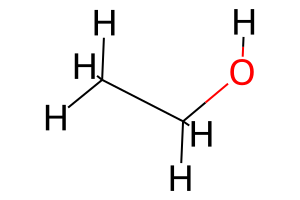

ML-derived energy: 0.0000 kcal/mol
MMFF energy: -1.3369 kcal/mol
Difference: 1.3369 kcal/mol
Molecule: c1ccccc1


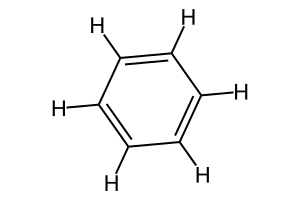

ML-derived energy: 0.0000 kcal/mol
MMFF energy: 16.2270 kcal/mol
Difference: 16.2270 kcal/mol
Molecule: CC(=O)O


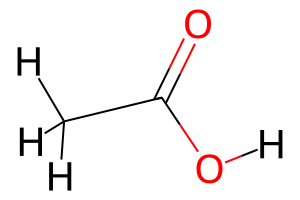

ML-derived energy: 0.0000 kcal/mol
MMFF energy: -26.4059 kcal/mol
Difference: 26.4059 kcal/mol
Molecule: CC#N


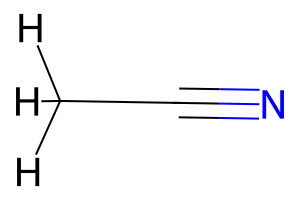

ML-derived energy: 0.0000 kcal/mol
MMFF energy: 0.0246 kcal/mol
Difference: 0.0246 kcal/mol
Molecule: C=C


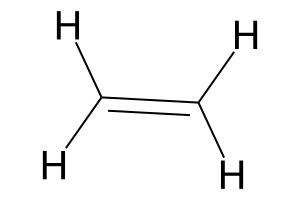

ML-derived energy: 0.0000 kcal/mol
MMFF energy: 8.2001 kcal/mol
Difference: 8.2001 kcal/mol


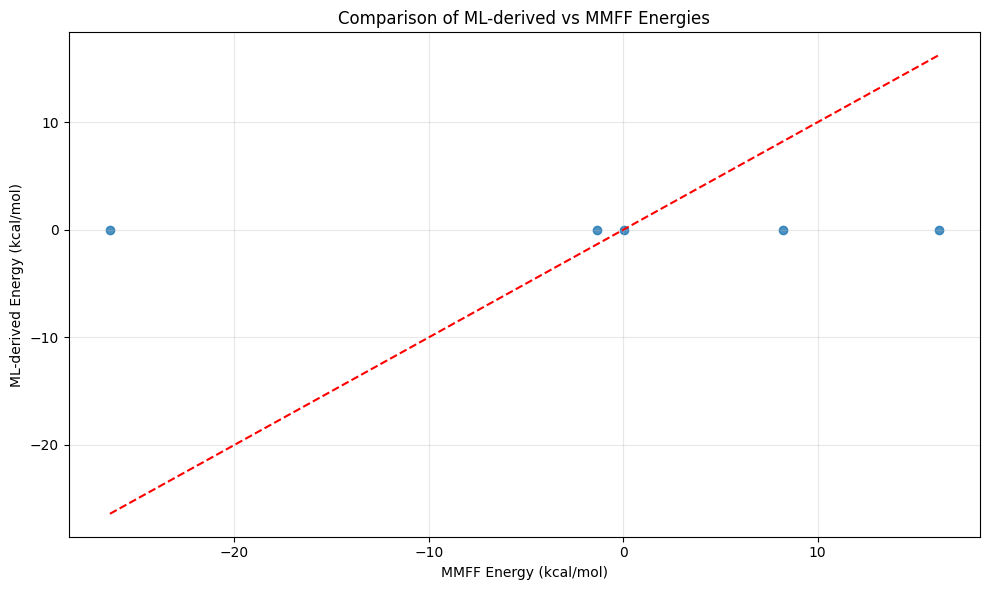

In [19]:
def calculate_bond_energy(mol, kb_values, r0_values):
    """Calculate bond energy using our predicted parameters"""
    energy = 0.0
    conf = mol.GetConformer()

    for i, bond in enumerate(mol.GetBonds()):
        atom1_idx = bond.GetBeginAtomIdx()
        atom2_idx = bond.GetEndAtomIdx()

        # Get current bond length
        bond_length = rdMolTransforms.GetBondLength(conf, atom1_idx, atom2_idx)

        # Get force constant and equilibrium bond length
        kb = kb_values[i]
        r0 = r0_values[i]

        # Calculate bond energy: E = kb * (r - r0)^2
        bond_energy = kb * (bond_length - r0)**2
        energy += bond_energy

    return energy

def compare_energies(smiles, kb_model, r0_model, feature_columns):
    """Compare ML-derived energies with MMFF94 energies"""
    # Create molecule
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)

    # Get features for ML prediction
    features = extract_bond_features(mol, -1)

    if features.empty:
        print("Could not extract features for this molecule")
        return

    # Prepare features for prediction
    X_new = pd.get_dummies(features[['bond_type', 'is_conjugated', 'is_in_ring',
                                   'atom1_atomic_num', 'atom2_atomic_num',
                                   'atom1_degree', 'atom2_degree',
                                   'atom1_hybridization', 'atom2_hybridization',
                                   'atom1_is_aromatic', 'atom2_is_aromatic',
                                   'atom1_is_in_ring', 'atom2_is_in_ring',
                                   'atom1_element', 'atom2_element']],
                           columns=['atom1_element', 'atom2_element'])

    # Handle missing columns
    for col in feature_columns:
        if col not in X_new.columns:
            X_new[col] = 0

    # Only use columns that were in the training data
    X_new = X_new[feature_columns]

    # Predict parameters
    kb_pred = kb_model.predict(X_new)
    r0_pred = r0_model.predict(X_new)

    # Calculate energy using our parameters
    ml_energy = calculate_bond_energy(mol, kb_pred, r0_pred)

    # Calculate MMFF energy for comparison
    mmff_props = AllChem.MMFFGetMoleculeProperties(mol)
    mmff_energy = AllChem.MMFFGetMoleculeForceField(mol, mmff_props).CalcEnergy()

    print(f"Molecule: {smiles}")
    display(Draw.MolToImage(mol, size=(300, 200)))
    print(f"ML-derived energy: {ml_energy:.4f} kcal/mol")
    print(f"MMFF energy: {mmff_energy:.4f} kcal/mol")
    print(f"Difference: {abs(ml_energy - mmff_energy):.4f} kcal/mol")

    return {
        'smiles': smiles,
        'ml_energy': ml_energy,
        'mmff_energy': mmff_energy
    }

# Compare energies for a few molecules
energy_comparisons = []
test_molecules = ['CCO', 'c1ccccc1', 'CC(=O)O', 'CC#N', 'C=C']

for smiles in test_molecules:
    result = compare_energies(smiles, model_kb, model_r0, X.columns)
    if result:
        energy_comparisons.append(result)

# Plot energy comparisons
energy_df = pd.DataFrame(energy_comparisons)

plt.figure(figsize=(10, 6))
plt.scatter(energy_df['mmff_energy'], energy_df['ml_energy'], alpha=0.8)
plt.plot([energy_df['mmff_energy'].min(), energy_df['mmff_energy'].max()],
         [energy_df['mmff_energy'].min(), energy_df['mmff_energy'].max()], 'r--')
plt.xlabel('MMFF Energy (kcal/mol)')
plt.ylabel('ML-derived Energy (kcal/mol)')
plt.title('Comparison of ML-derived vs MMFF Energies')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Save models and important data
import pickle

# Create a dictionary with all important objects
workflow_data = {
    'kb_model': model_kb,
    'r0_model': model_r0,
    'feature_columns': list(X.columns),
    'training_stats': {
        'kb_mse': kb_mse,
        'kb_r2': kb_r2,
        'r0_mse': r0_mse,
        'r0_r2': r0_r2
    }
}

# Save to file
with open('ml_force_field_models.pkl', 'wb') as f:
    pickle.dump(workflow_data, f)

# Download the saved models
files.download('ml_force_field_models.pkl')

# To load the models later:
# with open('ml_force_field_models.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
# loaded_kb_model = loaded_data['kb_model']
# loaded_r0_model = loaded_data['r0_model']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Create a summary report
print("## ML-Based Force Field Parameter Optimization Summary")
print("\n### Dataset")
print(f"- Total molecules: {len(successful_indices)} (from {len(smiles_list)} initial molecules)")
print(f"- Total bonds analyzed: {len(bond_data)}")
print(f"- Features used: {X.shape[1]}")

print("\n### Model Performance")
print("Force Constants (kb):")
print(f"- MSE: {kb_mse:.4f}")
print(f"- R²: {kb_r2:.4f}")
print("\nEquilibrium Bond Lengths (r0):")
print(f"- MSE: {r0_mse:.6f}")
print(f"- R²: {r0_r2:.4f}")

print("\n### Top Features for Force Constant Prediction")
for i, (feature, importance) in enumerate(zip(kb_feature_importance['feature'].head(5),
                                            kb_feature_importance['importance'].head(5))):
    print(f"{i+1}. {feature}: {importance:.4f}")

print("\n### Next Steps")
print("1. Expand dataset with more diverse molecules")
print("2. Add angle and torsion parameters")
print("3. Use real QM data instead of MMFF94")
print("4. Implement full molecular dynamics validation")
print("5. Explore other ML algorithms (Neural Networks, etc.)")

## ML-Based Force Field Parameter Optimization Summary

### Dataset
- Total molecules: 20 (from 20 initial molecules)
- Total bonds analyzed: 172
- Features used: 22

### Model Performance
Force Constants (kb):
- MSE: 0.0000
- R²: 1.0000

Equilibrium Bond Lengths (r0):
- MSE: 1.104912
- R²: 0.7657

### Top Features for Force Constant Prediction
1. bond_type: 0.0000
2. is_conjugated: 0.0000
3. atom2_element_O: 0.0000
4. atom2_element_N: 0.0000
5. atom2_element_H: 0.0000

### Next Steps
1. Expand dataset with more diverse molecules
2. Add angle and torsion parameters
3. Use real QM data instead of MMFF94
4. Implement full molecular dynamics validation
5. Explore other ML algorithms (Neural Networks, etc.)
